In [3]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import trackpy as tp
from scipy import ndimage
import nplocate as nl

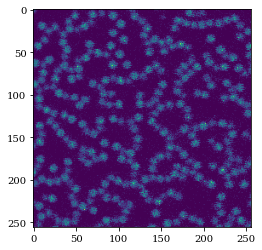

In [2]:
fn = '0_5_Efield_nosalt_27_11_20.tif'

img_obj = Image.open(fn)
zxy = []

for i in range(img_obj.n_frames):
    img_obj.seek(i)
    zxy.append(np.array(img_obj.convert('L')))
zxy = np.array(zxy)
xyz = np.moveaxis(zxy, 0, -1)

xyz = xyz[:256, :256, :]  # take only a fraction

plt.imshow(xyz[:, :, 5])
plt.show()

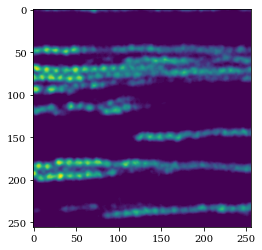

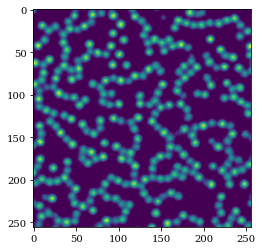

In [5]:
img = ndimage.median_filter(xyz, 3)
img = ndimage.gaussian_filter(img, 1)

plt.imshow(img[5])
plt.show()
plt.imshow(img[:, :, 5])
plt.show()

In [9]:
diameter = 9
xyz = tp.locate(img, diameter=diameter)
xyz = np.array(xyz)[:, :3]
xyz_tp = xyz.copy()  # store the result to compare with the refined results

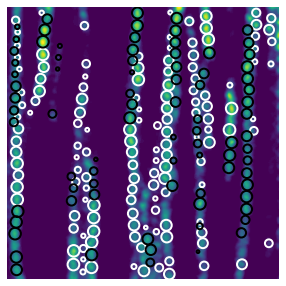

In [54]:
nl.see_slice(img, xyz_tp, s=150, radius=5.5, axis=0, sizes=(5, 5))

In [12]:
should_add = True
r_model = 2 * diameter
iter_num = 0
while should_add:
    n0 = xyz.shape[0]
    xyz = nl.add(
        positions=xyz,
        image=img,
        r_model=r_model,
        diameter=diameter,
        locate_func=lambda im : np.array(tp.locate(im, diameter))[:, :3],
        threshold=20
    )
    n1 = xyz.shape[0]
    should_add = n1 > n0
    iter_num += 1
    print('#{}, {} -> {}'.format(iter_num, n0, n1))

#1, 4985 -> 5795
#2, 5795 -> 5867
#3, 5867 -> 5869
#4, 5869 -> 5869


In [36]:
xyz = nl.refine(xyz, img, r_model, diameter)

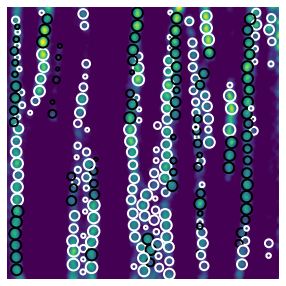

In [55]:
nl.see_slice(img, xyz, s=150, radius=5.5, axis=0, sizes=(5, 5))

In [44]:
d_measure = gr[0][np.argmax(gr[1])]

gr = nl.get_gr(positions=xyz, cutoff=d_measure * 5, bins=81)

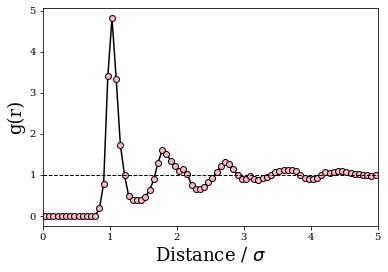

In [45]:
plt.plot(gr[0] / d_measure, gr[1], color='k', marker='o', mfc='lightpink')
plt.plot((0, 5), (1, 1), color='k', lw=1, ls='--')
plt.xlim(0, 5)
plt.xlabel('Distance / $\sigma$', fontsize=18)
plt.ylabel('g(r)', fontsize=18)
plt.show()

In [47]:
d_measure = gr[0][np.argmax(gr[1])]

x = 4/3 * np.pi * (d_measure / 2)**3 / (img.shape[0] - d_measure)**3 * xyz.shape[0]
print(f'{x * 100:.04} %')

27.98 %
